In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    precision_score, recall_score, f1_score
)
from sklearn.utils import class_weight
from tensorflow.keras.metrics import Precision

df = pd.read_csv("data-preperation/preprocessed-data/input-data/GOOG.csv")

2024-11-29 12:03:07.764652: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-29 12:03:07.794404: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 12:03:07.794434: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 12:03:07.794459: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 12:03:07.801123: I tensorflow/core/platform/cpu_feature_g

In [1]:
# Not including the 365 day simple moving average, as we are deleting all empty rows, this would create a year of empty rows
del df['365_day_SMA']

df['Date'] = pd.to_datetime(df['Date'])

# Defining the target. Comparing close price to the next days close price.
df['Target'] = (df['Close'] > df['Close'].shift(1)).astype(int)

# Drop all empty rows. This is done to later normalize the data.
df = df.dropna()


# Selecting the features that we want to include as input to the model
features = [
    'Open',
    'High',
    'Low',
    'Close',
    '7_day_SMA',
    '30_day_SMA',
    'Daily_Return'
]

X = df[features].values
y = df['Target'].values

# The length of the sequences sent to the model.
seq_length = 30

# Split index is this exact number to align with the GRU approach to have similar amount of test data points.
# This is important as the amount of times the price increases should be similar for the different implementations.
split_index = 971
X_train_raw = X[:split_index]
X_test_raw = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

print(len(y_test))

NameError: name 'df' is not defined

In [3]:
## Normalizing the data after it has been split into test and train. This is explained in the report, but is done to avoid data leakage.
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Function to creating the sequences.
def create_sequences(features, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(features) - seq_length):
        X_seq.append(features[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

x_train, y_train_seq = create_sequences(X_train_scaled, y_train, seq_length)
x_test, y_test_seq = create_sequences(X_test_scaled, y_test, seq_length)

# Class weights is used to penalize the model for wrongfully predicting the majority class. This was done in an attempt to avoid converging to always predicting one class.
class_weights = class_weight.compute_class_weight(
    'balanced', classes=[0, 1], y=y_train_seq
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Two definitions of the model, one using bidirectional and one does not.

# def create_lstm_model(input_shape):
#     model = Sequential([
#         LSTM(units=64, return_sequences=True, input_shape=input_shape, activation='tanh'),
#         Dropout(0.2),
#         BatchNormalization(),
#         LSTM(units=32, return_sequences=False, activation='tanh'),
#         Dropout(0.2),
#         Dense(units=1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

def create_bidirectional_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(units=64, return_sequences=True, activation='tanh'), input_shape=input_shape),
        Dropout(0.2),
        BatchNormalization(),
        Bidirectional(LSTM(units=32, return_sequences=False, activation='tanh')),
        Dropout(0.2),
        Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision')])
    return model

input_shape = (x_train.shape[1], x_train.shape[2])
regressorLSTM = create_bidirectional_lstm_model(input_shape)

# Training the model
history = regressorLSTM.fit(
    x_train, y_train_seq, 
    validation_data=(x_test, y_test_seq),
    epochs=300, batch_size=64, 
    class_weight=class_weight_dict, verbose=1
)

# Predicting the test set. See the last line of the loop that uses a treshold to determine whether prediction is 0 or 1.
all_predictions = []
for i in range(len(x_test)):
    x_test_sample = x_test[i].reshape(1, x_test.shape[1], x_test.shape[2])
    prediction = regressorLSTM.predict(x_test_sample, verbose=0)[0, 0]
    all_predictions.append(1 if prediction >= 0.50 else 0)

# Storing data for evaluation
all_predictions = np.array(all_predictions)
precision = precision_score(y_test_seq, all_predictions)
recall = recall_score(y_test_seq, all_predictions)
f1 = f1_score(y_test_seq, all_predictions)
accuracy = accuracy_score(y_test_seq, all_predictions)

# Printing model scores.
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Printing confusion matrix and classification report
print(confusion_matrix(y_test_seq, all_predictions))
print(classification_report(y_test_seq, all_predictions))

2024-11-29 12:03:12.111980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18073 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.20gb, pci bus id: 0000:e1:00.0, compute capability: 8.0


Epoch 1/300


2024-11-29 12:03:15.375988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-29 12:03:16.367995: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7e0df8020490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-29 12:03:16.368035: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.20gb, Compute Capability 8.0
2024-11-29 12:03:16.373235: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-29 12:03:16.439965: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 5s 72ms/step - loss: 0.7005 - accuracy: 0.5090 - precision: 0.5140 - val_loss: 0.6851 - val_accuracy: 0.5658 - val_precision: 0.5658
Epoch 2/300
15/15 [==============================] - 0s 20ms/step - loss: 0.7048 - accuracy: 0.5303 - precision: 0.5311 - val_loss: 0.6886 - val_accuracy: 0.5658 - val_precision: 0.5658
Epoch 3/300
15/15 [==============================] - 0s 20ms/step - loss: 0.7148 - accuracy: 0.4878 - precision: 0.4910 - val_loss: 0.6856 - val_accuracy: 0.5658 - val_precision: 0.5658
Epoch 4/300
15/15 [==============================] - 0s 18ms/step - loss: 0.7037 - accuracy: 0.5027 - precision: 0.5084 - val_loss: 0.6873 - val_accuracy: 0.5658 - val_precision: 0.5658
Epoch 5/300
15/15 [==============================] - 0s 20ms/step - loss: 0.7022 - accuracy: 0.4973 - precision: 0.5020 - val_loss: 0.6873 - val_accuracy: 0.5658 - val_precision: 0.5658
Epoch 6/300
15/15 [==============================] - 0s 19ms/step - loss: 0.7072 -

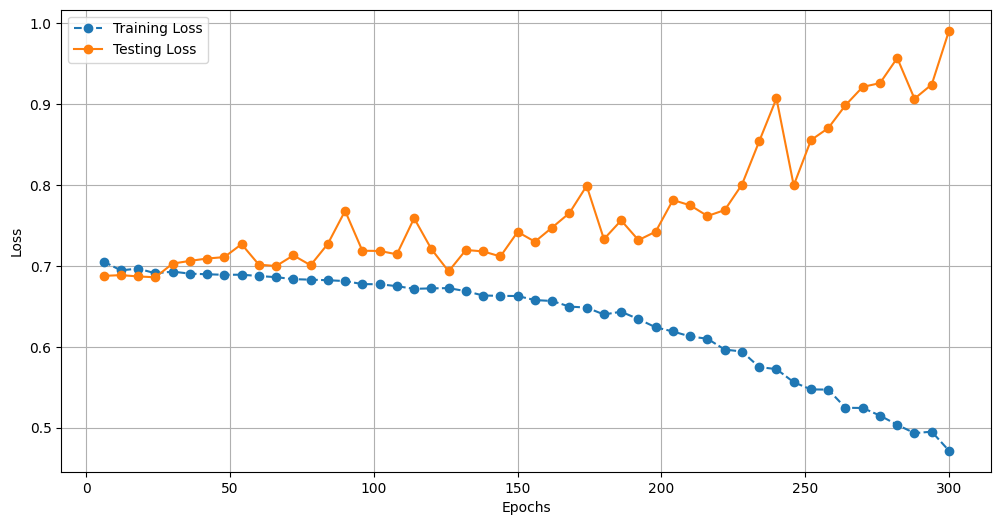

In [4]:
## Plotting the loss for the graph using moving averages. This is done as the loss fluctuate a lot.

epochs = int(history.epoch[-1]) + 1
moving_average_window = 6

def moving_average(data, window_size=2):
    return [np.mean(data[i:i+window_size]) for i in range(0, len(data) - window_size + 1, window_size)]

train_loss = moving_average(history.history['loss'], window_size=moving_average_window)
val_loss = moving_average(history.history['val_loss'], window_size=moving_average_window)

ma_epochs = list(range(moving_average_window, epochs + 1, moving_average_window))

plt.figure(figsize=(12, 6))
plt.plot(ma_epochs, train_loss, label="Training Loss", marker='o', linestyle='--')
plt.plot(ma_epochs, val_loss, label="Testing Loss", marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.grid(True)
plt.show()

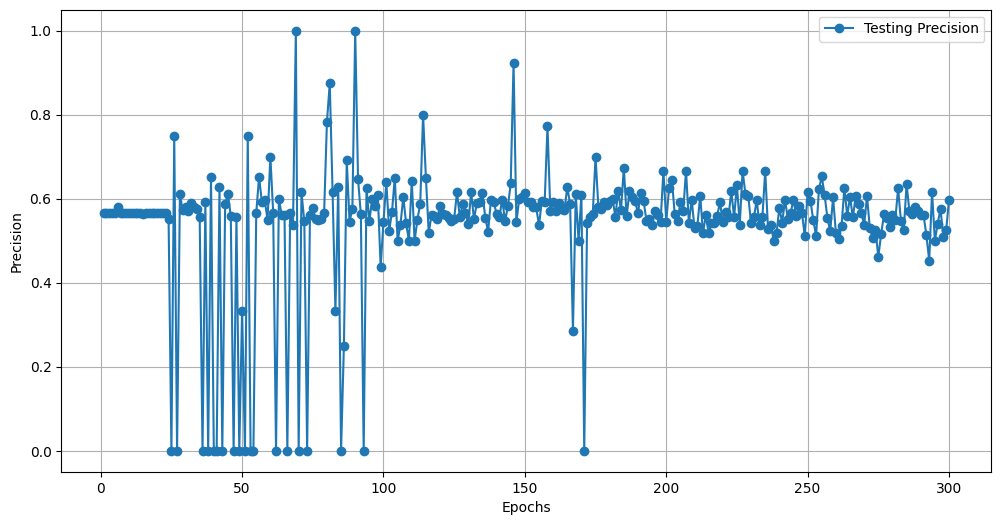

In [6]:
# Plotting precision scores for all epochs. 

val_precision = history.history['val_precision']
epoch_numbers = list(range(1, len(val_precision) + 1))

plt.figure(figsize=(12, 6))
plt.plot(epoch_numbers, val_precision, label="Testing Precision", marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc="best")
plt.grid(True)
plt.show()